# Yelp Data Challenge - NLP
We will build a sentiment analysis system for the review texts. Such a system would be useful in pinpointing difficulties encountered by businesses --- or their successes, for that matter. Useful, when we don't have time to comb through many reviews.

In this project, we will simulate encountering new data with a heldout test set.

## Load data
We will use the DataFrame constructed in `Data_Preprocessing.ipynb`. It contains reviews of restaurants from Las Vegas from approximately the last 2 years.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv')
df.head(3)

,business_id,name,categories,avg_stars,attributes,cool,date,funny,review_id,stars,text,useful,user_id
0,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2017-04-01,0,Spl0fx_X6bjPASU-zUJQUA,1,"Ordered a pizza, the location is literally in ...",1,vZ-eQzpCOrSWfBfU5KUvIA
1,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2016-11-20,0,2UV-a8pXUdbK0fdurFwXfQ,5,Very busy place but they take good care of you...,0,nu6wU6PLbL9HPLZuqon0-A
2,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2018-03-27,0,vG5m3TzOf5F52jzO2D_19g,3,Stopped here to pick up an order of wings on m...,0,KEerqlFNhzl1I-yVK6mHVA


In [3]:
# Minor number of NAs in 'attributes'; fortunately, we won't need that feature
pd.DataFrame.sum(df.isna())

business_id     0
name            0
categories      0
avg_stars       0
attributes     84
cool            0
date            0
funny           0
review_id       0
stars           0
text            0
useful          0
user_id         0
dtype: int64

### Extract review texts

In [4]:
# Take the values of the column that contains review text data, save to a variable named "documents"
documents = df.text

There are 101569 reviews in total.
Sample: Ordered a pizza, the location is literally in front of my apartment complex and my pizza was cold. Must have been sitting there for for almost an hour for as cold as it was, the drive from this location to my apartment door is all of anout five minutes. I ordered a soda and its
obvious it was never placed in a fridge. Cold pizza and warn soda. Horrible!


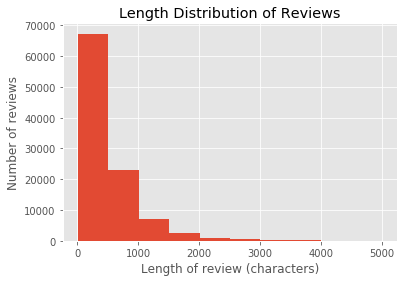

In [5]:
'''
    Inspect documents --- check length, and display example.
    
    We see that reviews come in various lengths. Deep learning approaches using RNNs may work,
    but it would be quite troublesome/RAM-consuming to pad/cut the reviews to an appropriate, uniform length.
    Therefore, we will adopt a bag-of-words approach, to acceptable results
'''

plt.hist(documents.apply(len))
plt.title("Length Distribution of Reviews")
plt.ylabel("Number of reviews")
plt.xlabel("Length of review (characters)")

print("There are {} reviews in total.".format(len(documents)))
print("Sample: {}".format(documents[0]))

### Define target variable

Let's distinguish between perfect (5 stars) and imperfect (1-4 stars) ratings. The assumption is that if a user gives a rating lower than 4, then there are potential room for improvements!

In [10]:
# Make a column and take the values, save to a variable named "target"
target = df.stars
target = (target == 5) #True if perfect
target = target.astype('int')

In [11]:
# Fortunately, target variable is almost balanced. 
target.value_counts()

0    52978
1    48591
Name: stars, dtype: int64

## Splitting into training and test sets

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Now split the data into training set and test set
# Use the (default) 75-25 split

documents_train, documents_test, target_train, target_test = train_test_split(documents, target, 
                                                                              test_size=0.20,
                                                                              random_state=49)

## Obtain NLP representation of `documents`

Term frequency–inverse document frequency (Tf-idf) representation of single words is used here.

We are **NOT** going to filter out the NLTK stopwords, because some of them may indicate sentiment: 'don't', 'weren't' ... basically, grammatical constructs that may be useful for our task. 

In fact, I tried filtering out stopwords on train-test splits generated from different `random_state`'s. It hurt classification accuracy for ~1%.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [15]:
# Some of the stopwords may actually carry sentiment
print(stopwords.words('english')) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [19]:
# Create TfidfVectorizer, and name it vectorizer
# Filter out only the most basic stop words
vectorizer = TfidfVectorizer(stop_words=["a", "an", "the", "m", "re", "s", "t", "of"])

In [20]:
# Fit the vectorizer with training data
vectorizer.fit(documents_train)
X_train = vectorizer.transform(documents_train)

# Use the trained vectorizer to transform test data
X_test = vectorizer.transform(documents_test)

In [21]:
# Get the vocab of your tfidf
vocab = vectorizer.vocabulary_
print("Vocabulary contains {} items".format(len(vocab)))

Vocabulary contains 50471 items


## Build Search Engine for 'Similar' Reviews
Once we have identified a review as positive/negative, we may want to search for other similar reviews to get a better picture of the data or the restaurant(s). Here, similarity is calculated based on Tf-idf features, and experimentally cosine similarity proves to give reasonable results.

From experience working with word embeddings

In [22]:
import numpy as np

# Helper functions for selecting search engine results 

def get_top_values(lst, n, labels):
    '''
    INPUT: LIST, INTEGER, LIST
    OUTPUT: LIST

    Given a list of values, find the indices with the highest n values.
    Return the labels for each of these indices.

    e.g.
    lst = [7, 3, 2, 4, 1]
    n = 2
    labels = ["cat", "dog", "mouse", "pig", "rabbit"]
    output: ["cat", "pig"]
    '''
    return [labels[i] for i in np.argsort(lst)[::-1][:n]]  # np.argsort by default sorts values in ascending order

def get_bottom_values(lst, n, labels):
    '''
    INPUT: LIST, INTEGER, LIST
    OUTPUT: LIST

    Given a list of values, find the indices with the lowest n values.
    Return the labels for each of these indices.

    e.g.
    lst = [7, 3, 2, 4, 1]
    n = 2
    labels = ["cat", "dog", "mouse", "pig", "rabbit"]
    output: ["mouse", "rabbit"]
    '''
    return [labels[i] for i in np.argsort(lst)[:n]]

In [23]:
# Test helper functions from above
print( get_bottom_values(lst=[7, 3, 2, 4, 1], n=2, labels = ["cat", "dog", "mouse", "pig", "rabbit"]) ) 
print( get_top_values(lst=[7, 3, 2, 4, 1], n=2, labels = ["cat", "dog", "mouse", "pig", "rabbit"]) )

['rabbit', 'mouse']
['cat', 'pig']


In [24]:
# Let's use cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
# Draw an arbitrary review from test (unseen in training) documents
review_ind = 2103
review = X_test[review_ind, :]

(array([5.9290e+03, 1.7631e+04, 2.2718e+04, 1.8443e+04, 1.0485e+04,
        4.4360e+03, 1.3190e+03, 2.6300e+02, 2.9000e+01, 2.0000e+00]),
 array([0.        , 0.03178577, 0.06357154, 0.09535731, 0.12714308,
        0.15892885, 0.19071462, 0.22250039, 0.25428616, 0.28607193,
        0.3178577 ]),
 <a list of 10 Patch objects>)

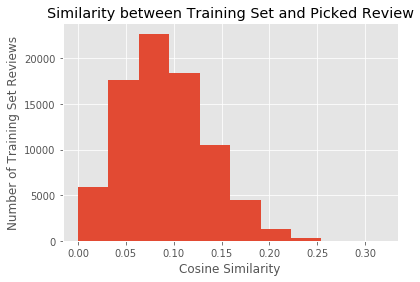

In [26]:
# Calculate the similarity score(s) between vector(s) and training vectors
similarity = cosine_similarity(X_train, review)
similarity = similarity.reshape(len(similarity),)

# Cosine similarity ranges from abs(0, 1)
# But even the top values are rather close to 0 ... Expect mediocre results
plt.title("Similarity between Training Set and Picked Review")
plt.ylabel("Number of Training Set Reviews")
plt.xlabel("Cosine Similarity")
plt.hist(similarity)

In [27]:
# Let's find top 4 similar reviews
top_similar_reviews = get_top_values(lst=similarity, n=4, labels=documents_train.values)

In [28]:
# Print search results!
# At the very least, the top search result is somewhat relevant to the input query
# They both discuss an evening meal, and share the same concerns of cold food

print('Our search query:')
print(documents_test.iloc[review_ind]) 
print()

print('Most %s similar reviews:' % len(top_similar_reviews))
for i, review in enumerate(top_similar_reviews):
    print("___ Review {} ___".format(i+1))
    print(review)
    print("___END___\n")

Our search query:
My family and I went to hash house last night. I had been once before and thought it was great. My Father was in town and I thought it would be a good idea to treat him to an acclaimed restaurant he had never been to before.I was terribly disappointed! The service was good , however, the food was cold and a real let down. In the past I was used to waiting in line to be seated. Last night, we were maybe 1 of 5 or 6 tables being served in the whole place which concerned me to begin with. My concerns were most certainly confirmed!

Most 4 similar reviews:
___ Review 1 ___
Went to the restaurant last night. It was a little after 8pm. Went to check in and was told there would be an hour and a half wait. We decided to order to go. After ordering was told It would be about 20 minutes.  That wasn't the case. We were probably there an hour waiting. As we looked at the line to eat in the restaurant,  all of the people that were before us and about 5 more people got seated befor

* Q: Do the results make sense?

* A: It seems we are lucky with the particular review picked. All the top similar reviews discuss Indian restaurants
and their curries; two of them also discussed the taste of the chicken served. Cannot guarantee globally acceptable performance, but don't have better (and simple) ideas now.

## Classifying positive/negative review

1. Build **logistic regression** classifier first, because its coefficients are the easiest to interpret. That would help us understand the language used in the reviews better.
2. Then, build multinomial **naive Bayes** (NB) classifier. Given how training and running a NB model is very quick, if it performs reasonably well it may just serve as the production model!
3. Finally, build and tune a **random forest**, and hopefully get an even higher accuracy.

We can use **accuracy** as our metric, because the classes are almost balanced.

#### Logistic Regression Classifier
No hyperparameters to tune, especially when classes are almost balanced!

In [31]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver="lbfgs", max_iter=200)
lr_clf.fit(X_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
# Get mean accuracy for training set
lr_clf.score(X_train, target_train)

0.8711340840563657

In [33]:
# Get mean accuracy for test set. 
# Not bad! Let's hope RandomForest can beat LR; if not, LR works well enough anyway.
lr_clf.score(X_test, target_test)

0.847986610219553

#### Q: Which features (words) that tend to produce a positive/negative prediction?

Glad to see that features with the most positive/negative coefficients in logistic regression actually correspond to positive/negative sentiments! (Remember, positive = 1, negative = 0) 

In [34]:
# Must first create a mapping from feature index to actual word
ix_to_words = {ix:word for word,ix in vocab.items()}

top_positive_words = get_top_values(lst=lr_clf.coef_[0], n=10, labels=ix_to_words)
print(top_positive_words)

top_negative_words = get_bottom_values(lst=lr_clf.coef_[0], n=10, labels=ix_to_words)
print(top_negative_words)

['amazing', 'best', 'awesome', 'delicious', 'excellent', 'perfect', 'fantastic', 'incredible', 'great', 'highly']
['worst', 'horrible', 'ok', 'rude', 'okay', 'terrible', 'disappointing', 'not', 'bland', 'slow']


#### (Multinomial) Naive Bayes Classifier
Technically multinomial naive Bayes should be fed integer features, but according to [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) fractional tf-idf values work in practice, too. 

In [35]:
from sklearn.naive_bayes import MultinomialNB

# Default settings of Laplace smoothing, and computing class priors from data
nb_clf = MultinomialNB(alpha=1.0, fit_prior=True)
nb_clf.fit(X_train, target_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
# Get mean accuracy for training set
nb_clf.score(X_train, target_train)

0.8405267368161959

In [38]:
# Get mean accuracy for test set. 
# Not bad! If 81% is still accceptable, definitely should consider deploying NB model
# It's quick to run and update *online*
nb_clf.score(X_test, target_test)

0.8183518755538053

## Cross validate, and (hopefully) find an even better classifier

Linear classifers, i.e. logistic regression and naive Bayes, are already performing quite alright with 80%+ accuracy. Let's see if we can do even better using more complicated, non-linear classifiers. Random forest in this case.

Random search is preferred over grid search when each iteration takes a long time; that *will* be the case with random forests. Hence, I am searching over randomly generated `max_depth` and `max_features`. In addition, I would like to cap `n_estimators` at 100, as a further measure to save time; the manually defined values should be spread-out enough to identify which region works the best.

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [55]:
# For repeatable experiments
np.random.seed(2)

In [51]:
total_number_of_features = X_train.shape[1]
log10_total_number_of_features = np.log10(total_number_of_features)

# Sample uniformly the *order of magnitude* (a la Andrew Ng in deeplearning.ai course)
# For key parameters e.g. learning rate in neural nets, and max_features in random forest, should do so
max_features_to_try = np.ceil( np.power(10, np.random.random(size=5)*log10_total_number_of_features) ) 
max_features_to_try = max_features_to_try.astype(int)

# Must print to validate that there are no duplicates
print(max_features_to_try)

[  141  1952 10782  9935 23581]


In [56]:
# Ditto; must print
max_depth = np.random.choice(range(10, 50), size=5, replace=False)
print(max_depth)

[37 19 24 10 12]


In [57]:
'''
    The cost of using a more complicated model: you have to tune its hyperparameters!
    First start with random search for optimal max_features and max_depth
    Then, follow-up with finer grid search
    
    Note that we won't go beyond n_estimators=100, because that simply takes too long to tune...
'''

rf_paramgrid = {
    'max_depth': max_depth,
    'n_estimators': (10, 30, 60, 100),
    'max_features': max_features_to_try,
}

grid_rf = GridSearchCV(cv=3, 
                       estimator=RandomForestClassifier(), 
                       param_grid=rf_paramgrid, 
                       scoring='accuracy', n_jobs=2)

grid_rf.fit(X_train, target_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': array([37, 19, 24, 10, 12]), 'n_estimators': (10, 30, 60, 100), 'max_features': array([  141,  1952, 10782,  9935, 23581])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [67]:
print("After 3-fold randomized CV, Random Forest achieves a mean accuracy of {}".format(grid_rf.best_score_))
print("The training accuracy is {}".format(grid_rf.score(X_train, target_train)))

After 3-fold randomized CV, Random Forest achieves a mean accuracy of 0.8117654298197035
The training accuracy is 0.9655159682481078


In [59]:
# These are the hyperparameters found, after a randomized search
print(grid_rf.best_params_)

{'max_depth': 37, 'max_features': 1952, 'n_estimators': 100}


In [61]:
# Fine tuning around the parameter set found above!

rf_paramgrid_finetune = {
    'max_depth': (34, 37, 40),
    'n_estimators': (100,),
    'max_features': (1800, 1900, 1952, 2000),
}

grid_rf_finetune = GridSearchCV(cv=3, 
                                estimator=RandomForestClassifier(), 
                                param_grid=rf_paramgrid_finetune, 
                                scoring='accuracy', n_jobs=2)

grid_rf_finetune.fit(X_train, target_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'max_depth': (34, 37, 40), 'n_estimators': (100,), 'max_features': (1800, 1900, 1952, 2000)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [65]:
print(grid_rf_finetune.best_params_)

{'max_depth': 37, 'max_features': 1800, 'n_estimators': 100}


In [108]:
print("After fine tuning, random forest achieves a mean accuracy of {} on 3-fold CV".format(grid_rf_finetune.best_score_))
print("The train accuracy is {}".format(grid_rf_finetune.score(X_train, target_train)))
print("The test accuracy is {}".format(grid_rf_finetune.score(X_test, target_test)))

After fine tuning, random forest achieves a mean accuracy of 0.812368469632638 on 3-fold CV
The train accuracy is 0.9665251369146514
The test accuracy is 0.8120508024022841


So accuracy has gone up by 0.012% after tuning. The benefits are miniscule compared to the (long) time it took to test all the hyperparameters. Would it be possible to train more quickly, while retaining a similiar level of performance?

### Dimension reduction using PCA; may help with overfitting?
As we can see from above, random forest is overfitting on the training data. Let's try reducing data dimensions using PCA, and fit random forest on the transformed set; hopefully that helps.

Using TruncatedSVD because it can work with sparse matrices directly. Also, according to [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html), it is a common choice for working with Tf-idf matrices.

In [69]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score

In [70]:
# The original number possible of features
X_train.shape[1]

50471

In [109]:
# Extract principal components
# First test an especially large value of n_components, then cut back if possible
pca = TruncatedSVD(n_components=5000)

0.8684114188183585


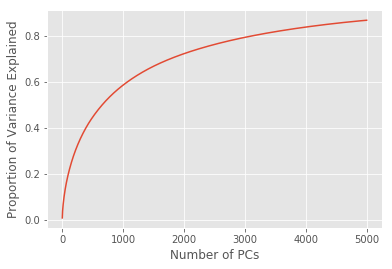

In [122]:
# 5000 principal components, 10% the original amount of features, explain ~86% of the variance
# But even if we take just half of that, we can still explain over 70%
# Let's go with n_components=3000 / 80% explained

print(pca.explained_variance_ratio_.sum())

plt.xlabel("Number of PCs"); plt.ylabel("Proportion of Variance Explained")
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [123]:
# In principle, can just use array indexing to retain the 3000 PCs?
# But anyway, retrained to have access to them in a convenient object form...

pca = TruncatedSVD(n_components=3000)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Now that we have reduced the # of feature dimensions, let's retrain some of the models again, and compare their performance to before dimension reduction.

In [147]:
### No hit in test performance for logistic regression, while train accuracy went down by ~2%
### PCA probably succeeded in taking out noise features, and thus reduced overfitting. Good!

lr_pca = LogisticRegression(solver="lbfgs")
lr_pca.fit(X_train_pca, target_train)

print("Logistic regression, train accuracy: ", lr_pca.score(X_train_pca, target_train))
print("Logistic regression, test accuracy: ", lr_pca.score(X_test_pca, target_test))

Logistic regression, train accuracy:  0.8588517629684327
Logistic regression, test accuracy:  0.8470512946736241


In [148]:
### What about random forest?

rf_pca = RandomForestClassifier(n_estimators=30, max_features=300, max_depth=20, n_jobs=4)
rf_pca.fit(X_train_pca, target_train)

# Training accuracy
print(rf_pca.score(X_train_pca, target_train))

# Test accuracy
print(rf_pca.score(X_test_pca, target_test))

### Overfitting still!
### More tuning is possible, but when there are simpler models that perform alright, it's not worth the time.

0.987631530367362
0.7706015555774343


## Summary of Steps Taken + Results

### Obtained vector representation of text reviews
Tf-idf vectors, with only basic filtering of stop words.

### Basic search engine for "similar" reviews
Given a query in text; searches corpus and return the most similar reviews. Cosine similarity is used here, because it is insentive; therefore the search engine can still function alright, even when the query is much shorter or longer than corpus documents.

### Sentiment analysis
Both logistic regression and multinomial naive Bayes easily achieved over 80% of accuracy, on both training and test sets. While logistic regression performs 3-4% better, if prediction speed or training time is really an issue, naive Bayes is definitely a viable alternative.

On the other hand, at least for the present amount of data, tuning random forest takes too long for the performance gain obtained. It easily overfits on the training data, and after elaborate, randomized hyperparameter search it only achieves the same accuracy as naive Bayes! Not worth exploring unless with a more powerful computer.